<a href="https://colab.research.google.com/github/quangviet/python4engineer/blob/main/Problem_1/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Thông tin học viên**

Học viên: Phạm Quang Việt

Mã học viên: 22MSE23069

Email: viet22mse23069@fsb.edu.vn

#**Bài 1 - Python for Developers (MSE):**

Đọc hiểu tutorial One Tutorial to Understand All (M5-Forecasting) phần EDA trên Kaggle và chú thích lại bằng tiếng Việt.

### Về cuộc thi M5-Forecasting

Cuộc thi sử dụng data thu thập được từ dữ liệu thực tế của Walmart để dự báo lượng bán hàng trong 28 ngày tiếp theo.
Dữ liệu bao gồm khoảng 30,000 mặt hàng bán trong 1,900 ngày từ 3 bang của nước Mỹ. Các thông tin bao gồm giá, khuyến mãi, thời gian và các thông tin bổ sung khác như loại hàng hoá, cửa hàng etc.

### Mô tả vấn đề:

Để có thể dự đoán được lượng hàng hoá bán ra trong 28 ngày tiếp theo, các câu hỏi dạng SMART (cụ thể, đo đạc được, có thể đạt được,có liên quan và có giới hạn thời gian) sau cần được trả lời.

- Phân phối của sales_items(ids) theo từng categories?
- What is the behavior of categories across different stores?
- What specific item id is outselling the most? 
- What is the specific id of item in each category that has most sales?
- What is the most sales revenue collected? Is the item id that is outselling the most brings in the most revenue or is there variation along those trends?
- What is the behavior of total sales (or mean sales) across time
- What is the behavior of item_ids selling across different weekdays? Are there any specfic dates of the month when there are most sales?How does this trend change across different stores?

Do đề bài chỉ dừng lại ở bước trực quan hoá dữ liệu, mô hình dự đoán lượng hàng bán ra chưa được đề cập đến trong notebook này.

## Chuẩn bị dữ liệu

### Tải tập dữ liệu từ Kaggle
Sử dụng API của Kaggle để download data set và giải nén vào thư mục input

In [24]:
%env KAGGLE_USERNAME=quangviet
%env KAGGLE_KEY=e78ec69319c278806b1208176ad50255
!kaggle competitions download -c m5-forecasting-accuracy
!unzip -o /content/m5-forecasting-accuracy.zip -d ./input

env: KAGGLE_USERNAME=quangviet
env: KAGGLE_KEY=e78ec69319c278806b1208176ad50255
m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/m5-forecasting-accuracy.zip
  inflating: ./input/calendar.csv    
  inflating: ./input/sales_train_evaluation.csv  
  inflating: ./input/sales_train_validation.csv  
  inflating: ./input/sample_submission.csv  
  inflating: ./input/sell_prices.csv  


### Chuẩn bị các thư viện

Notebook này sử dụng các thư viện 
- Numpy - Xử lý dữ liệu mảng và đại số tuyến tính
- Pandas - Xử lý dữ liệu bảng và file csv
- Matplotlib - Trực quan hoá dữ liệu lên đồ thị
- Seaborn - Trực quan hoá dữ liệu thống kê
- Scipy - Thư viện khoa học, toán học
- Sklearn - Thư viện học máy
- Plotly - Vẽ đồ thị trực quan

Và một số thư viện hệ thống như time, math, datetime và các widget dùng để tương tác trực tiếp trong notebook


In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input/sample_submission.csv
./input/sell_prices.csv
./input/sales_train_evaluation.csv
./input/calendar.csv
./input/sales_train_validation.csv


### Mô tả tập dữ liệu:

Notebook sử dụng các tập dữ liệu như sau

* `calendar_df.csv` - Thông tin ngày hàng hoá được bán cũng như thông tin về ngày lễ hoặc hoặc các dịp đặc biệt
* `train_sales_df.csv` - Thông tin về dữ liệu bán hàng trong quá khứ theo từng sản phẩm, cửa hàng và phòng ban trong 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Chưa sử dụng trong notebook này 
* `sell_prices_df.csv` - Thông tin về giá sản phẩm bán ra theo của hàng và ngày bán
* `sales_train_evaluation.csv` - Thông tin bán hàng [d_1 - d_1941] (dùng cho bảng xếp hạng công khai)


### Đọc dữ liệu bằng pandas:

Pandas hỗ trợ đọc file dữ liệu format csv bằng pandas.read_csv()

In [26]:
sell_prices_df = pd.read_csv('./input/sell_prices.csv')
train_sales_df = pd.read_csv('./input/sales_train_validation.csv')
calendar_df = pd.read_csv('./input/calendar.csv')
submission_file = pd.read_csv('./input/sample_submission.csv')


### Hiển thị thông tin của tập dữ liệu:

Sử dụng pandas.core.frame.DataFrame.info() để lấy thông tin cơ bản của tập dữ liệu

In [27]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [28]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [29]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Quan hệ giữa các cửa hàng, mặt hàng, nhóm hàng hoá cũng như số lượng hàng hoá bán được theo thời gian có thể được phân tích dựa trên các thông tin ở trên.

Tập dữ liệu sử dụng có khoảng 6 triệu bản ghi hàng hoá bán ra (thông tin từ 'sell_prices_df') với 30,000 loại hàng hoá khác nhau (thông tin từ 'train_sales_df')

Dựa vào thông tin từ tập dữ liệu 'calendar_df', phân tích dữ liệu theo thời gian có thể được thực hiện.

## *Phân tích dữ liệu khám phá (EDA):*

### Phân phối và sự thay đổi theo thời gian của các hàng hoá bán ra

Để tiện phân tích dữ liệu, thông tin ngày bán hàng ('d_1 tới d_1913') và các thông tin khách ('store_id', 'state_id') được tách ra.

In [30]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [31]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Phân phối hàng bán ra theo chủng loại

In [32]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Phân phối hàng bán ra theo chủng loại')
fig.show()

Theo biểu đồ trên thì đồ ăn ('foods') là mặt hàng bán chạy nhất, tiếp thoel à đồ gia dụng ('household') và cuối cùng là mặt hàng giải trí ('hobbies')

In [33]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Phân bố mặt hàng bán ra theo từng bang')
fig.show()

Theo biểu đồ trên thì bang CA tiêu tiêu thụ số lượng hàng hoá nhiều nhất, tiếp theo đến bang TX và cuối cùng là bang WI

Để trực quan hơn, dữ liệu được chuyển sang đồ thị dạng cột và chia theo từng bang như bên dưới.

In [34]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

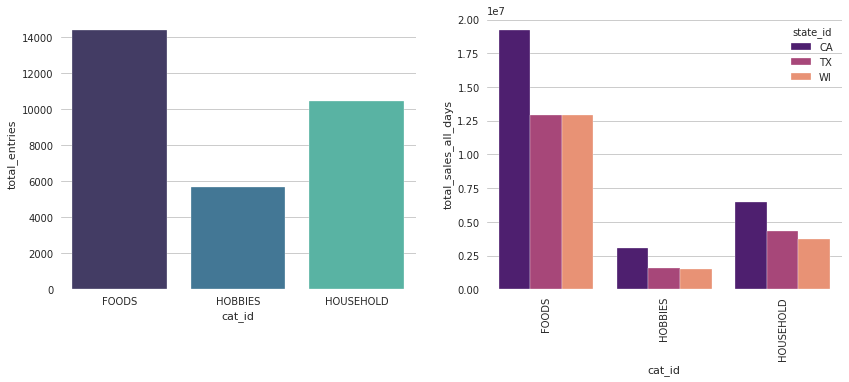

In [35]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)

plt.show()

Từ 2 đồ thị trên, có thể kết luận
- Nhóm mặt hàng bán ra nhiều nhất là thực phẩm ('foods'), tiếp theo đến 'household' và 'hobbies'
- Bang CA tiêu thụ nhiều sản phẩm nhất trên cả 3 nhóm hàng hoá. Bang WI tiêu thụ sản phẩm thực phẩm cao hơn bang TX và thấp hơn với 2 nhóm hàng hoá còn lại.

Phân phối lượng hàng hoá bán ra theo từng chủng loại và theo từng bang

In [36]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Phân phối lượng hàng hoá bán ra theo từng chủng loại và theo từng bang")


fig.show()

Theo đồ thị trên có thể thấy 
- Bang CA bán nhiều hàng hoá nhất
- Tổng lượng hàng hoá bán ra ở WI và TX là ngang bằng nhau

#### Phân bố hàng bán ra theo cửa hàng 

In [37]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [38]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Phân bố hàng hoá bán ra theo từng cửa hàng', 'Stores')
items_sold_per_days(df['state_id'], 'Phân bố hàng hoá bán ra theo từng bang', 'States')

Phân tích số liệu theo các biểu đồ trên cho thấy
- Hai nhóm mặt hàng bán chạy nhất là 'foods_3' và 'household_1'
- Phân bố hàng hoá bán ra theo cửa hàng ở 2 bang TX và WI không giống nhau mặc dù tổng sản phẩm bán ra trên từng chủng loại (category) có vẻ tương đương
- Cửa hàng bán chạy nhất ở các bang lần lượt là CA_3, TX_2 và WI_3

#### Hàng hoá nào bán chạy nhất

Vì tập dữ liệu 'train_sales_df' bao gồm thông tin về từng hàng hoá cụ thể và số lượng bán ra, ta có thể tìm hiểu mặt hàng nào bán chạy nhất.

Ta cũng có thể vẻ đồ thì biểu diễn kiểu phân bố hàng hoá bán ra trong ngày.

In [39]:
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Theo kết quả bên trên, có thể thấy là khi gộp theo 'id' thì "**FOODS_3_090_CA_3_validation**" là bán chạy nhất, tiếp theo là **"FOODS_3_586_TX_2_validation"**. 

Sản phẩm đầu tiên thuộc nhóm hàng 'food_3' và bán ra ở cửa hàng 'CA_3'

Tương tự, sản phẩm thứ 2 thuộc về cửa hàng 'TX_2' và cùng thuộc nhóm hàng 'food_3'

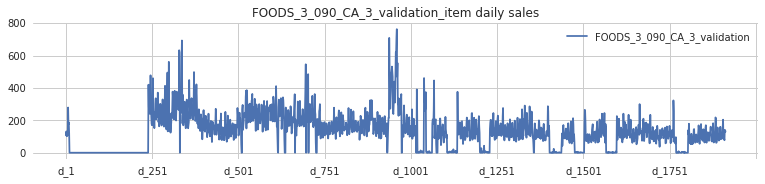

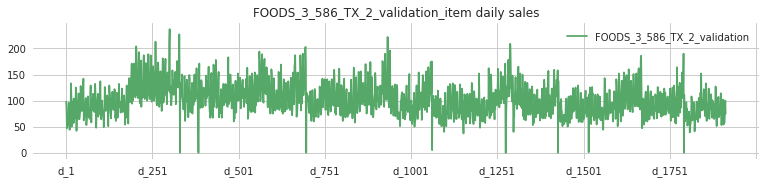

In [40]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Mặt hàng bán chạy nhất trong từng nhóm hàng hoá

In [41]:
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


Sau khi tập dữ liệu đã được sắp xếp giảm dần theo số hàng hoá bán ra, ta có thể dễ dàng tìm ra sản phẩm nào bán chạy nhất trong từng nhóm hàng hoá (category)

In [42]:
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [43]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

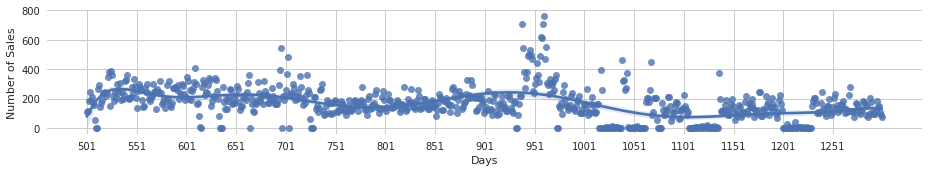

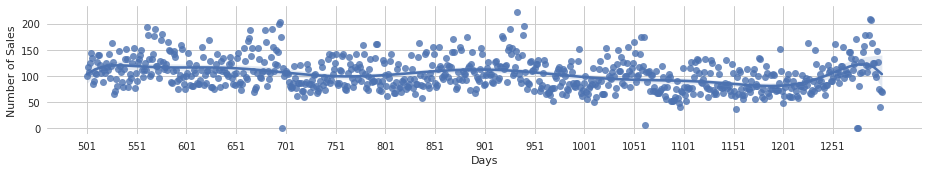

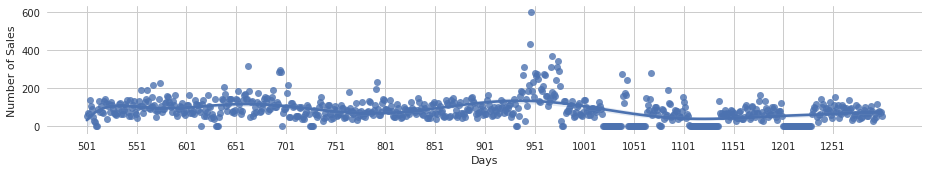

In [44]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)


Nhìn đồ thị trên có thể thấy mô hình hồi quy tuyến tính cho kết quả tương đối tốt trên kết quả dữ liệu bán hàng của 2 mặt hàng FOODS_3_090_CA_3_validation và FOODS_3_586_TX_2_validation từ ngày 500 đến ngày 900.

Đồ thị trên cũng cho thấy các đợt tăng nhiều khả năng rơi vào các ngày lễ hay các dịp đặc biệt.

### Phân tích doanh thu bán hàng

Vì tập dữ liệu không cung cấp id khớp theo giá bán (có 30,000 dữ liệu trong train_sales_df trong khi có 6 triệu dữ liệu trong sell_prices_df), nên ta chỉ có thể ước tính tương đối doanh thu một cách gần đúng.

Trong 'sell_prices_df' có thông tin về loại hàng hoá nên có thể đánh giá được doanh thu theo từng loại hàng hoá.

Trước hết, chúng tôi muốn tìm hiểu xem doanh thu cụ thể đối với từng sản phẩm là bao nhiêu? Nhưng vì chúng tôi chưa được cung cấp tập dữ liệu với id (product_ids) trong sell_prices_df (khung dữ liệu doanh thu) và có sự không khớp trong các mục nhập tập dữ liệu giữa cả hai tập dữ liệu (train_sales_df với gần 30000 hàng và sell_prices_df với gần 6 triệu mục nhập), do đó, atbest, một ước tính sơ bộ có thể được thực hiện bằng cách hợp nhất cả hai tập dữ liệu.

Thật tuyệt vời, Khung dữ liệu doanh thu (sell_prices_df) có sẵn dữ liệu cấp phân loại, vì vậy chúng tôi có thể ước tính về các mặt hàng được bán trong từng danh mục để xem giá cụ thể mà hầu hết các mặt hàng đang được bán là bao nhiêu.

Trước tiên ta thử điều chỉnh phương pháp phân phối xác suất phi tham số vì phân phối dữ liệu có thể không phản ánh chính xác của phân phối ta đã thấy trước đây và có thể bao gồm các đỉnh hoặc giá trị ngoại lai. (https://machinelearningmastery.com/probability-density-estimation/)

Nếu phân phối dữ liệu không giống với một phân phối đã biết, thì việc điều tra thêm sẽ được thực hiện để loại bỏ các dữ liệu ngoại lệ cụ thể.

In [45]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [46]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

#### Phân phối của giá cả các loại hàng hoá

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



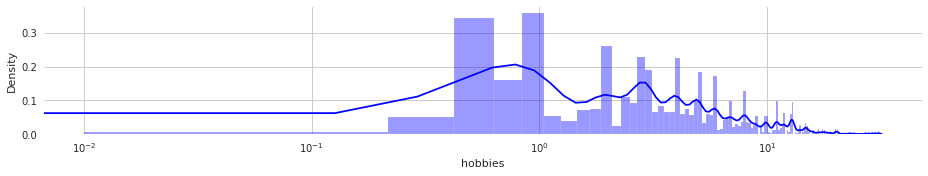

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



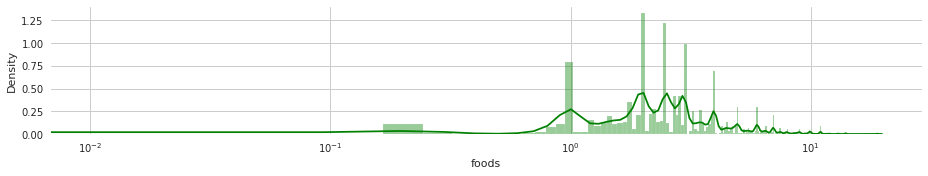

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



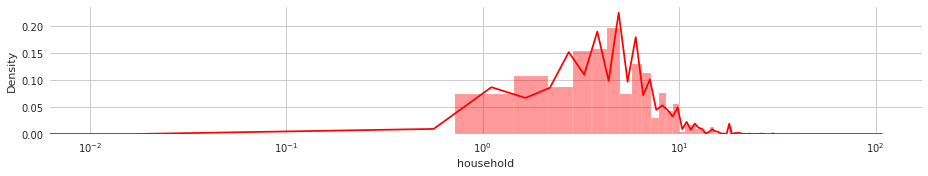

In [47]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

Dựa trên đồ thị bên trên, ta có thể nhận xét
- Phân phối của đồ gia dụng (household) gần giống phân phối chuẩn với trung bình nằm ở khoảng 5 dollar. Hầu hết các mặt hàng bán ra là trong khoảng 25 cent tới 10 dollar
- Phân phối của thực phẩm (foods) theo mô hình phân phối đa phương thức, phản ánh sự thay đổi thường xuyên với các mặt hàng được ưa chuộng. Giá của các mặt hàng thuộc hạng mục thực phẩm chủ yếu rtong khoảng 2 cent tới 10 dolldar.
- Phần phối của mặt hàng giải trí (hobbies) là mix giữa phân phối 2 và nhiều phương thức. Các mặt hàng giải trí được bán nhiều ở khoảng giá 1 cent tới 1 dollar, tuy nhiên cũng có nhiều mặt hàng được bán ra ở khoảng giá cao với các đỉnh giảm giần theo mức giá (kiểu phân phối đa phương thức - multimodal)

#### Xoá bỏ các điểm ngoại lệ
#### **Phương pháp tịnh tiến**

In [48]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



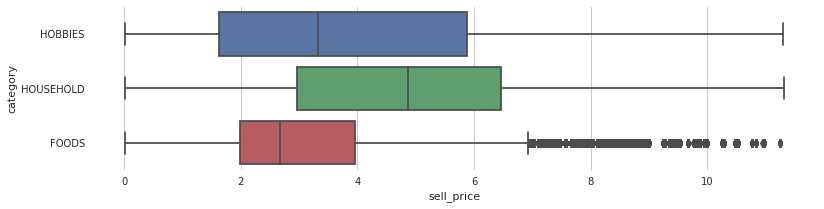

In [49]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

Sau khi loại bỏ các điểm ngoại lệ, có thể thấy
- 75% hàng thực phẩm được bán ra có giá dưới 4 dollar
- 75% hàng giải trí được bán ra có giá dưới 6 dollar và trung bình ở 3.25 - 3.5 dollar
- 75% hàng gia dụng được bán ra có giá dưới 6.5 dollar

Phân bố này khác tương đối so với trước khi loại bỏ các ngoại lệ cho thấy là có tương đối nhiều các điểm ngoại lệ trong tập dữ liệu.

(https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/)

### Phân phối hàng hoá bán ra theo ngày và các dịp đặc biệt

Dựa theo tập dữ liệu 'calendar_df' (bao gồm thông tin về ngày bán hàng, thông tin về các ngày lễ, sự kiện), ta sẽ phân tích sự phụ thuộc về số lượng hàng hoá bán ra theo thời gian.


In [58]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days,events_names,events_types
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31,NaN,NaN


In [59]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

Dữ liệu từ 'event_name_1' và 'event_type_1' sẽ giúp ta tìm hiểu xu hướng bán hàng trong các dịp lễ và sự kiện.

In [60]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

Có một số dữ liệu không dùng 'event_name_1'  mà dùng 'event_name_2'

In [61]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

#### Về **SNAP_CA, SNAP_TX, SNAP_WI**

SNAP là "Supplementary Nutrition Assistance Program" - một chương trình của chính phủ mỹ nhằm cung cấp một số thực phẩm thiết yếu cho các hộ thu nhập thấp và không bao gồm đồ gia dụng và đồ giải trí.

In [62]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

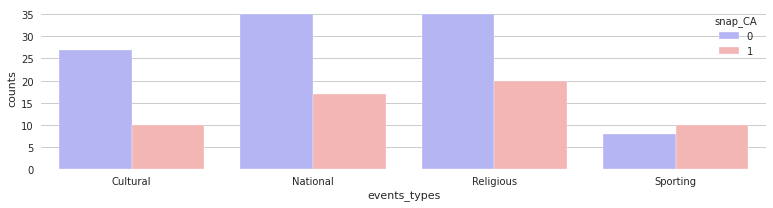

In [63]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [64]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

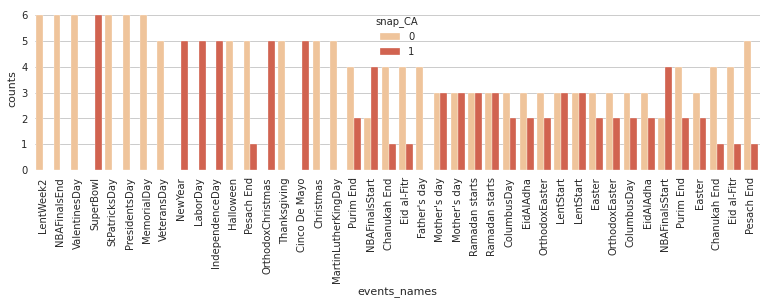

In [65]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

2 biểu đồ trên cho thấy các dịp đặc biệt mà SNAP được triển khai ở CA

### Phân phối của hàng bán ra và doanh thu

Dựa vào bộ dữ liệu 'ravenue_df' và product_id, ta có thể phân tích xu hướng của hàng hoá và giá cả bán ra

In [69]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', 
                                            #  on='item_id', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")


In [70]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

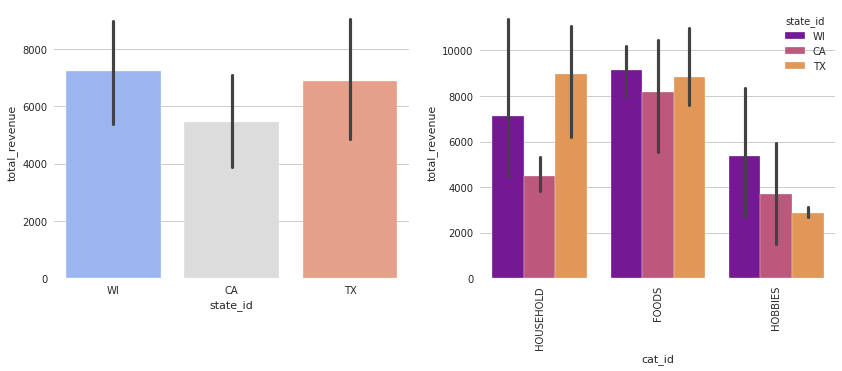

In [71]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

Mặc dù dữ liệu bán hàng có tới 6 triệu dữ liệu, ta chỉ xem xét những dữ liệu có trong revenue_df và product id. Từ các biểu đồ trên, ta có thể thấy
- Mặc dù CA có nhiều loại hàng hoá bán ra nhất, doanh thu cao nhất lại đến từ các cửa hàng ở WI
- Tương tự, bang TX cũng có doanh thu cao hơn mặc dù bán ít loại hàng hoá hơn bang CA
- WI dẫn đầu doanh thu về thực phẩm và giải trí, còn TX dẫn đầu doanh thu về đồ gia dụng
- CA có doanh thu thấp nhất mặc dù có nhiều hàng hoá bán ra nhất

### *Đánh giá và phân tích theo thời gian*

Phân tích theo thời gian giúp ta tìm hiểu sự liên quan của hàng hoá bán và thời điểm hàng hoá bán ra.

**Đường trung bình cộng** : Ta sử dụng trung bình cộng để làm mịn dữ liệu, từ đó có thể tìm ra tác động trong dài hạn của thời gian bán ra sản phẩm

#### Phân phối của tổng lượng hàng hoá bán ra theo thời gian

In [74]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [75]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [77]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Tổng lượng bán ra theo từng hàng hoá', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

Khó có thể nhìn ra xu hướng dựa vào tập dữ liệu đang có ngoài xu hướng tăng nhẹ theo thời gian.

Sử dụng seasonal_decompose module ở statsmodel, ta sẽ phân tích tiếp xu hướng theo thời gian. Trong trường hợp dữ liệu đang phân tích, 'multiplicative' là phương pháp phù hợp nhất.

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

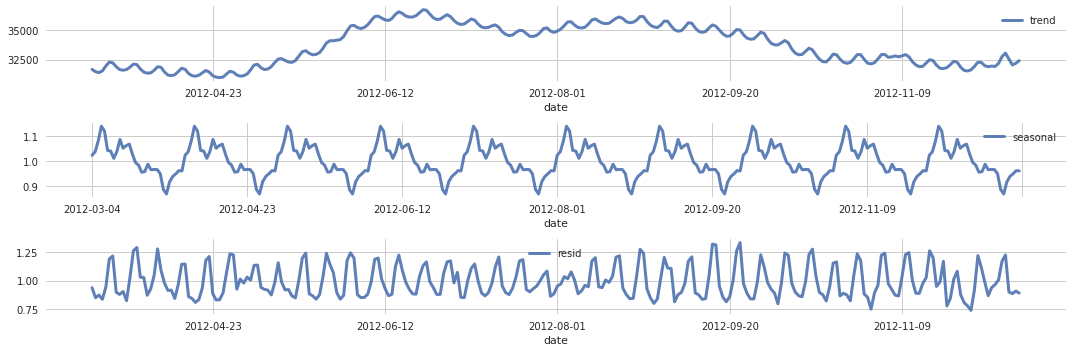

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

Theo biểu đồ xu hướng ở trên, chúng ta có thể rút ra
- Có tính thời vụ trong bộ dữ liệu
- Tính thời vụ này là kiểu theo cấp số nhân (multiplicative)

In [80]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [81]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

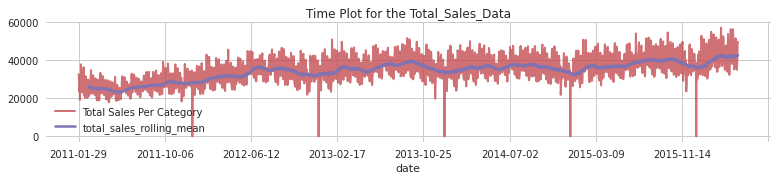

In [82]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

Theo biểu đồ có thể thấy là lượng hàng bán ra tăng dần theo thời gian.

Chúng ta sẽ phân tích tiếp xu hướng của một vài loại hàng hoá cụ thể theo thời gian.

In [84]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [86]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

Với 25 mặt hàng được bán nhiều nhất, TX dẫn đầu về số lượng hàng bán ra.


In [87]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

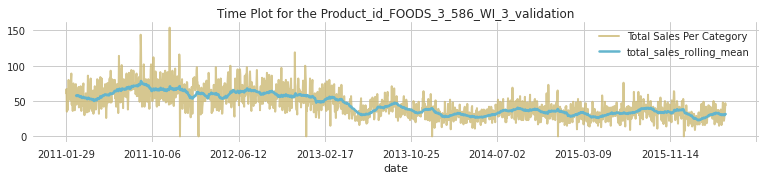

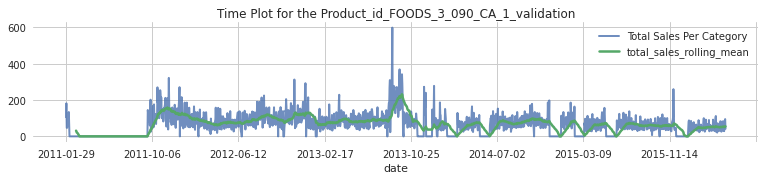

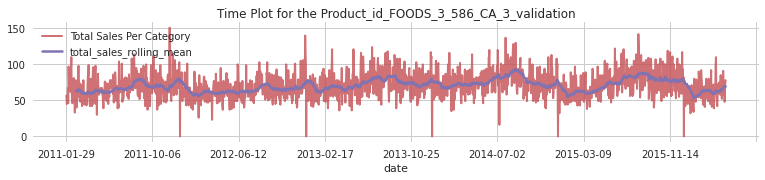

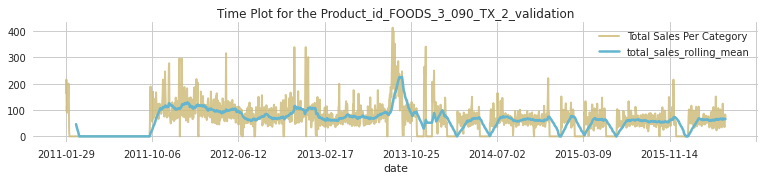

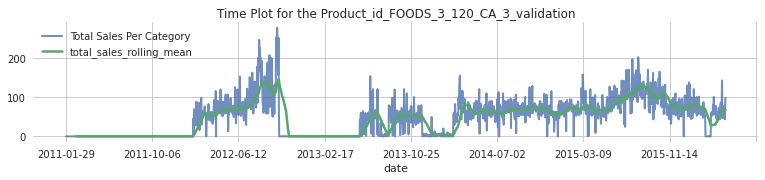

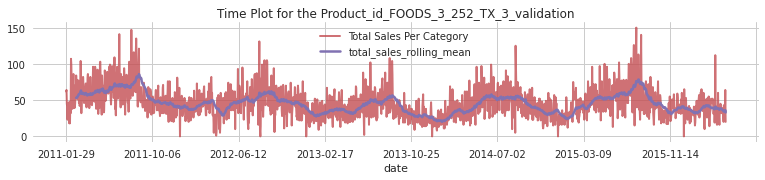

In [88]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

### Phân phối tổng lượng hàng hoá bán ra ở chủng loại

In [90]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [91]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [92]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

Biểu đồ trên cho thấy,
- Lượng hàng hoá bán ra thực sự tăng dần theo thời gian
- Hàng hoá ở nhóm thực phẩm và đồ gia dụng tăng rõ rệt hơn so với mặt hàng giải trí

#### Phân phối tổng lượng hàng bán ra theo bang

In [94]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

While there has been an increase in the number of sales across all three states i.e. CA, TX, and WI interesting to note is the fact that:

* There is an overall increase in the sales of items across all states
* WI sales cross TX sales at around Oct'14 and Sept'15 indicating that that could be boost in the sales of category of items that are seasonal. We'll try and investigate the sales of categories across separate states to further shed a light on this answer

In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum(axis=1).T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:617: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
#train_sales_cal_df = train_sales_cal_df.set_index('dates')

In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

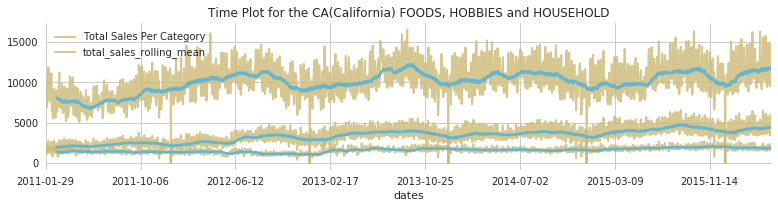

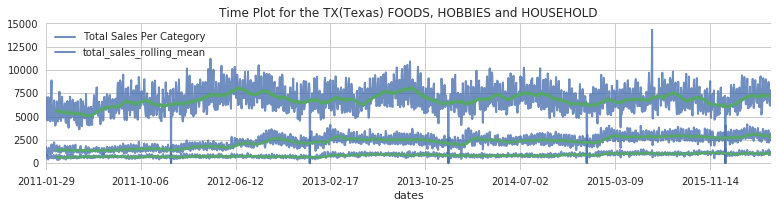

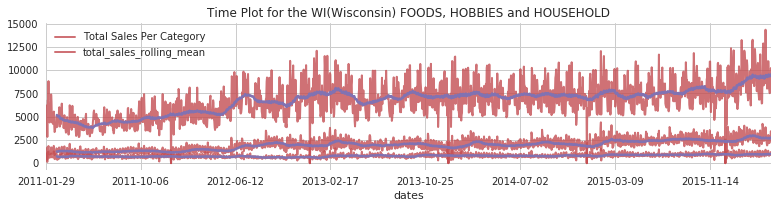

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

By looking at the above graphs, some of the trends regarding in the food distribution category along separate states have become evident. 

* Along the FOODS distribution, both CA and TX see large bumps in sales around june'12 and september'12-October'12 with the next peak coming around in Oct'13 that is larger than the sales in June'12 with the same trend continuing to repeat itself along other dates in 2014, and 2015
* However, the sales along WI stores have a slightly different pattern with peaks of sales occuring in July'12 and next largest being observed in Feb-Mar'13. Similarly, the sales pick up around September in 2013, and then in Mar'13

* In Household items distribution, the peaks of sales across all stores in CA, TX and WI occur around July, March while relatively huge dips in sales occuring in all three locations around the month of Jan-Feb. 

* In Hobbies items sales, there is surprising peak in sales (albiet different in actual number of units sold) across similar dates in all store locations (for example Feb'13 and Feb'15) with a slight dip in sale in Aug-Sep'13.

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


These are the five item ids that have been selling most in California and Texas locations.
* While the first one "FOODS_3_090_CA_3_validation" is the same as the one that was most sold during our earlier analysis, the second observation is quite different to earlier assessment and the item most sold in second place has id "FOODS_3_281_CA_3_validation"
* The items that were contributing to the sales bump of household items are also mentioned above. The household item sold most during the bump period is HOUSEHOLD_1_334_CA_3_validation 

### Distribution of Total Sales Vs Store_ID?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum(axis=1)\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

Looking at the above plot with respect to specific stores, it is indicative that:

* CA_3 store location has the most items sold
* CA_4 store location has the least items old across the timeline
* TX_2 has the most items sold across timeline with most items sales peaking around Sep'13
* All Texas store locations (TX_1, TX_2, TX_3) experience a boost in sales around Feb_Mar'15 , with a peak around August'15 and then bottom out around Dec'15
* Wisconsin Store locations experience a rather unpredictable pattern
* Store WI_2 accelerates past the sold of WI_3 in Dec'12 and then continues to maintain the lead
* Stores WI_2, WI_1 were underperformers in the beginning but experienced a boost in sales July'12 and November'12 respectively
* There appears to be a continuous decline in the performance of sold items for the store location WI_3 that are only relatively improved towards the end

### Distribution of Sales Per Specific Days/Weekends?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')


In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')